In [ ]:
!pip3 search argparse

In [ ]:
!pip3 install -q --user python-keystoneclient python-novaclient pandas

# Make sure to restart the kernel after running this cell

ERROR: caniusepython3 7.1.0 requires argparse, which is not installed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import re
import json
from novaclient import client as novac
from keystoneauth1.identity import v3
from keystoneauth1 import session
from keystoneclient.v3 import client as keystonec
from os import environ as env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# quota holds the currently assigned quota for each flavor / project
# 
# This is not a real quota tracker but a manual (temporary) workaround.
quota = {
    'batch.g1.1.4.8.120': {
        'IT-Batch - Geneva Project 047 - Dedicated': 6,
    },
    'batch.g1.4.16.64.320': {
        'IT-Batch - Geneva Project 047 - Dedicated': 6,
    },
    'batch.g2.1.4.16.120': {
        'IT-Batch - Geneva Project 047 - Dedicated': 6,
    },
    'batch.g2.4.16.64.590': {
        'IT-Batch - Geneva Project 047 - Dedicated': 6,
    },
    'g101.2xlarge': {
    },
    'g101.xlarge': {
        'IT Cloud Infrastructure Developers': 1,
        'IT Engineering - Telework': 1,
    },
    'g102.xlarge': {
        'Hub': 1,
        'TechLab': 1,
    },
    'g103.xlarge': {
    },
    'g105.xlarge': {
    },
    'g106.xlarge': {
        'IT Cloud Infrastructure Developers': 1,
        'IT-Batch - Geneva Project 047 - Dedicated': 6,
        'SWAN': 1,
        'Hub': 0,
    },
    'g107.xlarge': {
    },
    'g108.xlarge': {
        'TechLab': 1,
    },
    'g109.2xlarge': {
    },
    'g110.2xlarge': {
        'IT-Batch - Geneva Project 047 - Dedicated': 4,
    },
    'g111.xlarge': {
    },
    'g112.xlarge': {
    },
    'g113.xlarge': {
        'Cloud ML': 21,
        'IT SC Accelerators': 3,
    }
}
result = {}

In [3]:
# we need both nova and keystone clients
with open('admin-creds') as credsf:
    creds = json.load(credsf)
auth = v3.Password(**creds)
sess = session.Session(auth=auth)
keystone = keystonec.Client(session=sess)
nova = novac.Client('2', session=sess)

In [32]:
fls = nova.flavors.list(is_public=False, sort_key='name')
flavors = []
for fl in fls:
    if re.search('^(batch\.)*g[0-9]+\..*', fl.name):
        flavors.append("%s (%s)" % (fl.name, fl.get_keys()['pci_passthrough:alias']))
flavors.sort()

projects = {}

for fl in fls:
    if not re.search('^(batch\.)*g[0-9]+\..*', fl.name):
        continue
        
    flavorandgpu = "%s (%s)" % (fl.name, fl.get_keys()['pci_passthrough:alias'])
    # fetch project with flavor access
    accs = nova.flavor_access.list(flavor=fl.id)
    for acc in accs:
        project_name = keystone.projects.get(acc.tenant_id).name
        if not project_name in projects:
            projects[project_name] = [[0,0]] * len(flavors)

        servers = nova.servers.list(
            search_opts={'all_tenants': 'true', 'tenant_id': acc.tenant_id,
                         'flavor': fl.id}
        )
        projects[project_name][flavors.index(flavorandgpu)] = [len(servers), quota[fl.name][project_name]]
        print("%s :: %s :: %s :: %s" % (project_name, flavorandgpu, len(servers), quota[fl.name][project_name]))

IT-Batch - Geneva Project 047 - Dedicated :: batch.g1.1.4.8.120 (nvV100_VGA:1) :: 0 :: 6
IT-Batch - Geneva Project 047 - Dedicated :: batch.g1.4.16.64.320 (nvV100_VGA:4) :: 0 :: 6
IT-Batch - Geneva Project 047 - Dedicated :: batch.g2.1.4.16.120 (nvV100S_VGA:1) :: 12 :: 6
IT-Batch - Geneva Project 047 - Dedicated :: batch.g2.4.16.64.590 (nvV100S_VGA:4) :: 0 :: 6
IT Cloud Infrastructure Developers :: g101.xlarge (nvP1080ti_VGA:1) :: 1 :: 1
IT Engineering - Telework :: g101.xlarge (nvP1080ti_VGA:1) :: 0 :: 1
TechLab :: g102.xlarge (nvP1080_VGA:1) :: 1 :: 1
Hub :: g102.xlarge (nvP1080_VGA:1) :: 1 :: 1
IT Cloud Infrastructure Developers :: g106.xlarge (nvV100_VGA:1) :: 0 :: 1
SWAN :: g106.xlarge (nvV100_VGA:1) :: 1 :: 1
Hub :: g106.xlarge (nvV100_VGA:1) :: 0 :: 0
IT-Batch - Geneva Project 047 - Dedicated :: g106.xlarge (nvV100_VGA:1) :: 6 :: 6
TechLab :: g108.xlarge (nvP1080_VGA:2) :: 1 :: 1
IT-Batch - Geneva Project 047 - Dedicated :: g110.2xlarge (nvV100_VGA:4) :: 2 :: 4
IT SC Accelerator

In [33]:
def value(v):
    if v[0] == 0 and v[1] == 0:
        return "-"
    return "%d / %d" % (v[0], v[1])

def color(v):
    if v[0] >= v[1] and v[1] != 0:
        return 'color: red'
    elif v[0] == 0 and v[1] != 0:
        return 'color: blue'
    elif v[0] < v[1]:
        return "color: green"
    return "color: grey"

dfq = pd.DataFrame(projects, index=flavors)
dfq.style.applymap(color).format(value)

In [34]:
df = dfq.copy()
df = df.applymap(lambda x: x[0])
df

IT-Batch - Geneva Project 047 - Dedicated  \
batch.g1.1.4.8.120 (nvV100_VGA:1)                                             0   
batch.g1.4.16.64.320 (nvV100_VGA:4)                                           0   
batch.g2.1.4.16.120 (nvV100S_VGA:1)                                          12   
batch.g2.4.16.64.590 (nvV100S_VGA:4)                                          0   
g1.4xlarge (nvV100_VGA:4)                                                     0   
g1.xlarge (nvV100_VGA:1)                                                      0   
g101.2xlarge (nvP1080ti_VGA:1)                                                0   
g101.xlarge (nvP1080ti_VGA:1)                                                 0   
g102.xlarge (nvP1080_VGA:1)                                                   0   
g103.xlarge (nvP100_VGA:1)                                                    0   
g105.xlarge (aVega10_VGA:1)                                                   0   
g106.xlarge (nvV100_VGA:1)                                                    6   
g107.xlarge (nvP1080ti_VGA:2)                                                 0   
g108.xlarge (nvP1080_VGA:2)                                                   0   
g109.2xlarge (nvP1080ti_VGA:1)                                                0   
g110.2xlarge (nvV100_VGA:4)                                                   2   
g111.xlarge (nvV100_VGA:1)                                                    0   
g112.xlarge (nvT4_VGA:1)                                                      0   
g113.xlarge (nvV100S_VGA:1)                                                   0   
g2.xlarge (nvT4_VGA:1)                                                        0   
g3.4xlarge (nvV100S_VGA:4)                                                    0   
g3.xlarge (nvV100S_VGA:1)                                                     0   

                                      IT Cloud Infrastructure Developers  \
batch.g1.1.4.8.120 (nvV100_VGA:1)                                      0   
batch.g1.4.16.64.320 (nvV100_VGA:4)                                    0   
batch.g2.1.4.16.120 (nvV100S_VGA:1)                                    0   
batch.g2.4.16.64.590 (nvV100S_VGA:4)                                   0   
g1.4xlarge (nvV100_VGA:4)                                              0   
g1.xlarge (nvV100_VGA:1)                                               0   
g101.2xlarge (nvP1080ti_VGA:1)                                         0   
g101.xlarge (nvP1080ti_VGA:1)                                          1   
g102.xlarge (nvP1080_VGA:1)                                            0   
g103.xlarge (nvP100_VGA:1)                                             0   
g105.xlarge (aVega10_VGA:1)                                            0   
g106.xlarge (nvV100_VGA:1)                                             0   
g107.xlarge (nvP1080ti_VGA:2)                                          0   
g108.xlarge (nvP1080_VGA:2)                                            0   
g109.2xlarge (nvP1080ti_VGA:1)                                         0   
g110.2xlarge (nvV100_VGA:4)                                            0   
g111.xlarge (nvV100_VGA:1)                                             0   
g112.xlarge (nvT4_VGA:1)                                               0   
g113.xlarge (nvV100S_VGA:1)                                            0   
g2.xlarge (nvT4_VGA:1)                                                 0   
g3.4xlarge (nvV100S_VGA:4)                                             0   
g3.xlarge (nvV100S_VGA:1)                                              0   

                                      IT Engineering - Telework  TechLab  Hub  \
batch.g1.1.4.8.120 (nvV100_VGA:1)                             0        0    0   
batch.g1.4.16.64.320 (nvV100_VGA:4)                           0        0    0   
batch.g2.1.4.16.120 (nvV100S_VGA:1)                           0        0    0   
batch.g2.4.16.64.590 (nvV100S_VGA:4)                   

<Figure size 432x288 with 0 Axes>

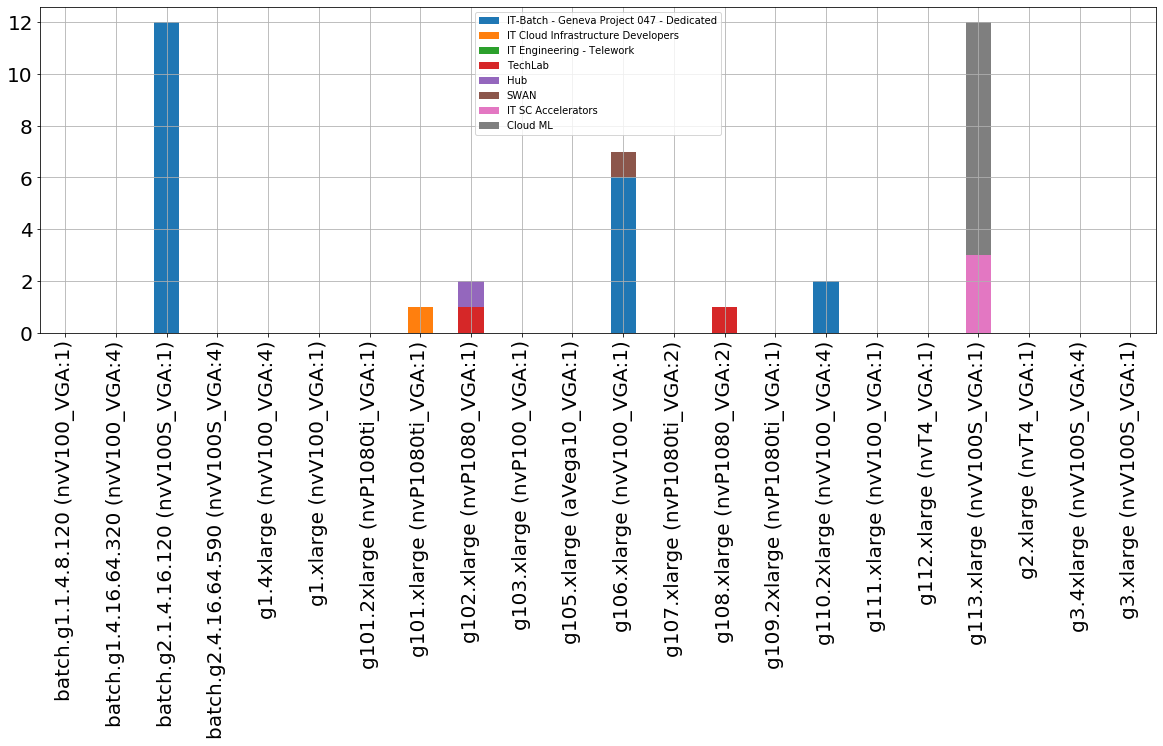

In [38]:
plt.figure()
df.plot.bar(stacked=True, figsize=(20,6), fontsize=20, grid=True)